$$ \nabla^2 \psi = -\frac{\rho(x)}{\epsilon}$$
<center>1D:
$ \nabla^2 f = \frac{d^2 f}{dx^2} \sim \Big(f(x-dx) + f(x+dx) - 2 f(x) \Big) / \Big(2 dx^2\Big)$</center>
$$ \Big(\psi(x-dx) + \psi(x+dx)\Big) /2 + \rho (dx)^2 / \epsilon  = \psi(x) $$


### R-cząstkowe 1D 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

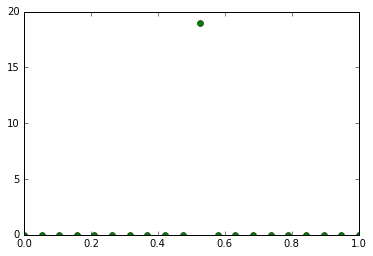

In [12]:
epsilon_zero = 1
x, dx = np.linspace(0, 1, 20, retstep = True)
charge = np.zeros_like(x)
charge[len(charge)//2] = 1/dx
potential = np.zeros(x.shape[0] + 2)

from funkcje import plottable

plt.plot(x, plottable(potential))
plt.plot(x, charge, "go")

In [3]:
def L2_norm(a, b):
    return np.sqrt(np.sum((a-b)**2))

def solve_poisson_jacobi(dx, potential, charge, epsilon = 1e-6, debug=True):
    """rozwiązuje równanie płazona
    zwraca tablicę z rozwiązaniem bez warunków brzegowych
    dx: krok przestrzenny na siatce
    potential: tablica rozmiaru N + 2, krawędzie zawierają warunki brzegowe
    charge: tablica rozmiaru N, ładunek na siatce
    
    $$ \Big(\psi(x-dx) + \psi(x+dx)\Big) /2 + \rho (dx)^2 / \epsilon  =
        = \psi(x) $$
    """
    
    L2_norm_current = 1
    i = 0
    
    potential1 = potential.copy()
    potential2 = potential.copy()
    while L2_norm_current > epsilon:
        i += 1
        potential2[1:-1] = (potential1[:-2] + potential1[2:])/2 +\
            charge*dx**2 / epsilon_zero
        L2_norm_current = L2_norm(potential1, potential2)
        potential1[:] = potential2
    if debug:
        print(i, L2_norm_current)
    return plottable(potential2)

solution = solve_poisson_jacobi(dx, potential, charge)

895 9.977364533e-07


(-2, 2)

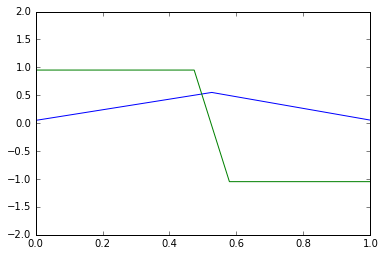

In [4]:
plt.plot(x, solution)
plt.plot(x, np.gradient(solution, dx))
plt.ylim(-2, 2)

In [13]:
charge2 = np.zeros_like(charge)
indices = (x > 0.3) * (x < 0.7)
charge2[indices] = 1/(0.4)
solution2 = solve_poisson_jacobi(dx, potential, charge2)

864 9.93987936532e-07


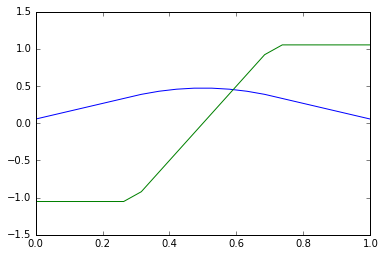

In [14]:
# plt.plot(x, charge2)
plt.plot(x, solution2)
plt.plot(x, -np.gradient(solution2, dx))

274 9.96896142514e-07


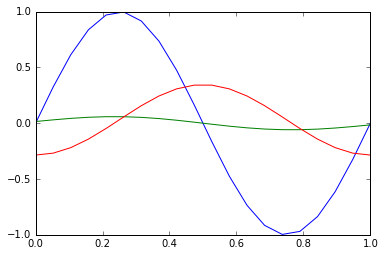

In [7]:
charge3 = np.sin(x*np.pi*2)
solution3 = solve_poisson_jacobi(dx, potential, charge3)
plt.plot(x, charge3)
plt.plot(x, solution3)
plt.plot(x, -np.gradient(solution3, dx))

In [8]:
%%timeit
solve_poisson_jacobi(dx, potential, charge3, debug=False)

10 loops, best of 3: 49.3 ms per loop


464 9.81800338954e-07


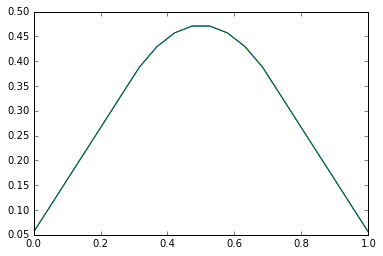

In [28]:
def solve_poisson_gauss(dx, potential, charge, epsilon = 1e-6, debug=True):
    """rozwiązuje równanie płazona
    zwraca tablicę z rozwiązaniem bez warunków brzegowych
    dx: krok przestrzenny na siatce
    potential: tablica rozmiaru N + 2, krawędzie zawierają warunki brzegowe
    charge: tablica rozmiaru N, ładunek na siatce
    
    $$ \Big(\psi(x-dx) + \psi(x+dx)\Big) /2 + \rho (dx)^2 / \epsilon  =
        = \psi(x) $$
    """
    
    L2_norm_current = 1
    j = 0
    
    potential1 = potential.copy()
    while L2_norm_current > epsilon:
        temporary_L2_norm = 0
        j += 1
        for i in range(1, len(potential1)-1):
            temp_value = (potential1[i-1] + potential1[i+1])/2 +\
                charge[i-1]*dx**2 / epsilon_zero
            
            difference = temp_value - potential1[i]
            potential1[i] = temp_value
            difference *= difference
            temporary_L2_norm += difference
        L2_norm_current = np.sqrt(temporary_L2_norm)
    if debug:
        print(j, L2_norm_current)
    return plottable(potential1)

solution_gs = solve_poisson_gauss(dx, potential, charge2)
plt.plot(x, solution_gs)
plt.plot(x, solution2)

In [20]:
%%timeit
solve_poisson_gauss(dx, potential, charge2, debug=False)

1 loop, best of 3: 254 ms per loop


In [32]:
import numba

def solve_poisson_gauss_fast(dx, potential, charge, epsilon = 1e-6, debug=True):
    #gottagofast
    """rozwiązuje równanie płazona
    zwraca tablicę z rozwiązaniem bez warunków brzegowych
    dx: krok przestrzenny na siatce
    potential: tablica rozmiaru N + 2, krawędzie zawierają warunki brzegowe
    charge: tablica rozmiaru N, ładunek na siatce
    
    $$ \Big(\psi(x-dx) + \psi(x+dx)\Big) /2 + \rho (dx)^2 / \epsilon  =
        = \psi(x) $$
    """
    
    potential1 = potential.copy()
    length = len(potential1) - 1
    
    @numba.jit(nopython=True)
    def numeryka():
        L2_norm_current = 1
        j = 0
        while L2_norm_current > epsilon:
            temporary_L2_norm = 0
            j += 1
            for i in range(1, length):
                temp_value = (potential1[i-1] + potential1[i+1])/2 +\
                    charge[i-1]*dx**2 / epsilon_zero

                difference = temp_value - potential1[i]
                potential1[i] = temp_value
                difference *= difference
                temporary_L2_norm += difference
            L2_norm_current = np.sqrt(temporary_L2_norm)
        if debug:
            print(j, L2_norm_current)
    numeryka()
    return plottable(potential1)

solution_gs = solve_poisson_gauss_fast(dx, potential, charge2)
plt.plot(x, solution_gs)
plt.plot(x, solution2)

TypingError: Failed at nopython (nopython frontend)
Internal error at <numba.typeinfer.SetItemConstraint object at 0xa97f330c>:
--%<-----------------------------------------------------------------
Traceback (most recent call last):
  File "/home/dominik/.anaconda3/lib/python3.5/site-packages/numba/typeinfer.py", line 114, in propagate
    constraint(typeinfer)
  File "/home/dominik/.anaconda3/lib/python3.5/site-packages/numba/typeinfer.py", line 435, in __call__
    sig = typeinfer.context.resolve_setitem(targetty, idxty, valty)
  File "/home/dominik/.anaconda3/lib/python3.5/site-packages/numba/typing/context.py", line 184, in resolve_setitem
    return self.resolve_function_type("setitem", args, kws)
  File "/home/dominik/.anaconda3/lib/python3.5/site-packages/numba/typing/context.py", line 112, in resolve_function_type
    res = defn.apply(args, kws)
  File "/home/dominik/.anaconda3/lib/python3.5/site-packages/numba/typing/templates.py", line 185, in apply
    sig = generic(args, kws)
  File "/home/dominik/.anaconda3/lib/python3.5/site-packages/numba/typing/arraydecl.py", line 176, in generic
    raise TypeError("Cannot modify value of type %s" %(ary,))
TypeError: Cannot modify value of type readonly array(float64, 1d, C)
--%<-----------------------------------------------------------------

File "<ipython-input-32-9798e8e3e378>", line 29

In [30]:
%%timeit
solve_poisson_gauss_fast(dx, potential, charge2, debug=False)

1 loop, best of 3: 3.18 s per loop


# 2D POISSON

In [34]:
a, b = c, d = 3, 4
a, b, c, d

(3, 4, 3, 4)

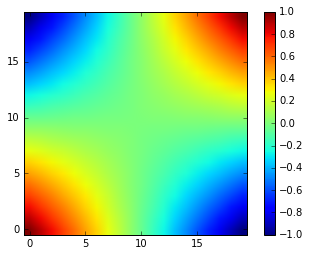

In [40]:
x, dx = y, dy = np.linspace(-1, 1, 20, retstep=True)
X, Y = np.meshgrid(x, y)
plt.imshow(Y*X, origin='lower')
plt.colorbar()

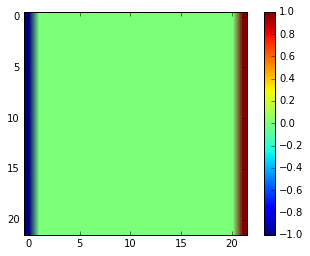

In [43]:
R2 = X**2 + Y**2
indices = R2 < 0.25
charge = np.zeros_like(X)
charge[indices] = 1
# plt.imshow(charge)
# plt.colorbar()
potential = np.zeros((len(x)+2, len(x) +2))
potential[:,0] = -1
potential[:,-1] = +1
plt.imshow(potential)
plt.colorbar()

In [54]:
def solve_poisson_jacobi_2d(dx, potential, charge, epsilon = 1e-6, debug=True):
    """rozwiązuje równanie płazona
    zwraca tablicę z rozwiązaniem bez warunków brzegowych
    dx: krok przestrzenny na siatce
    potential: tablica rozmiaru N + 2, krawędzie zawierają warunki brzegowe
    charge: tablica rozmiaru N, ładunek na siatce
    
    $$ \Big(\psi(x-dx) + \psi(x+dx)\Big) /2 + \rho (dx)^2 / \epsilon  =
        = \psi(x) $$
    """
    
    L2_norm_current = 1
    i = 0
    
    potential1 = potential.copy()
    potential2 = potential.copy()
    while L2_norm_current > epsilon:
        i += 1
        potential2[1:-1, 1:-1] = (potential1[:-2, 1:-1] +\
                                  potential1[2:, 1:-1] +\
                                  potential1[1:-1, :-2] +\
                                  potential1[1:-1, 2:])/4 +\
                                  charge*dx**2 / epsilon_zero
        L2_norm_current = L2_norm(potential1, potential2)
        potential1[:] = potential2
    if debug:
        print(i, L2_norm_current)
    return potential1[1:-1, 1:-1]

In [59]:
solution_2d = solve_poisson_jacobi_2d(dx, potential, charge)

927 9.96803278774e-07


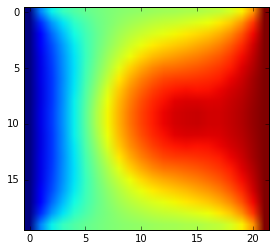

In [48]:
plt.imshow(solution_2d)

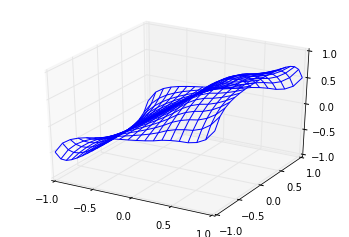

In [60]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# X.shape, Y.shape, solution_2d.shape
ax.plot_wireframe(X, Y, solution_2d)

### Argumenty

### Praca na wielu plikach skryptowych

### Interfejsy graficzne

In [11]:
np.gradient?